In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import setup, compare_models, tune_model, predict_model
import matplotlib as mpl
import matplotlib.pyplot as plt
%cd ..
from src.data_loader import OccupancyData, CaseData
%cd -
mpl.rcParams.update(mpl.rcParamsDefault)
%config InlineBackend.figure_format = 'svg'

/workspaces/hospitalization-model
/workspaces/hospitalization-model/notebooks


In [2]:
START_DATE = "2021-03-30"
END_DATE = "2022-03-30"
FORECAST_DAYS = 14

In [3]:
occupancy_data = OccupancyData("../data/hospitalization.csv")
case_data = CaseData("../data/age_groups.csv")
occupancy = occupancy_data.get_df(START_DATE, pd.to_datetime(END_DATE) + pd.Timedelta(days=FORECAST_DAYS), "Österreich", "ICU")
cases = case_data.get_df(START_DATE, pd.to_datetime(END_DATE) + pd.Timedelta(days=FORECAST_DAYS), "Österreich", 
                         age_groups=[">84", "75-84", "65-74", "55-64", "45-54"]).rolling(7, min_periods=1).mean()
data = occupancy.join(cases)

data['series'] = np.arange(1,len(data)+1)

train = data[:END_DATE]
test = data[END_DATE:]

features = ['cases']  # not using series as feature => poor performance

train = train[['occupancy'] + features]
test = test[['occupancy'] + features]

display(train.head())
display(test.head())

,occupancy,cases
date,,
2021-03-30,538,1265.000000
2021-03-31,531,1315.000000
2021-04-01,534,1289.333333
2021-04-02,537,1291.000000
2021-04-03,533,1267.200000


,occupancy,cases
date,,
2022-03-30,237,12245.000000
2022-03-31,226,11441.571429
2022-04-01,218,10606.285714
2022-04-02,215,9883.285714
2022-04-03,215,9270.428571


In [4]:
s = setup(data = train, test_data = test, target = 'occupancy', fold_strategy = 'timeseries', 
          numeric_features = features, fold = 10)

,Description,Value
0,Session id,7449
1,Target,occupancy
2,Target type,Regression
3,Data shape,"(381, 2)"
4,Train data shape,"(366, 2)"
5,Test data shape,"(15, 2)"
6,Numeric features,1
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [5]:
best = compare_models(turbo=False, sort='MAPE', n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,125.5175,27051.3514,140.3037,-41.4762,0.5884,0.8558,0.0260
knn,K Neighbors Regressor,124.9048,27447.3526,140.7198,-40.1014,0.5955,0.8762,0.0140
rf,Random Forest Regressor,126.0251,27786.5837,143.0590,-46.2983,0.6068,0.8876,0.0610
catboost,CatBoost Regressor,126.9630,27919.9770,144.1081,-51.4384,0.6122,0.8960,0.7190
gbr,Gradient Boosting Regressor,127.3030,28084.0812,144.8509,-53.1830,0.6138,0.8969,0.0160
et,Extra Trees Regressor,127.8359,28118.4634,144.4703,-50.2567,0.6132,0.8982,0.0610
xgboost,Extreme Gradient Boosting,132.1271,29953.6669,149.0889,-60.0022,0.6249,0.9119,0.0650
dt,Decision Tree Regressor,133.9091,30607.1030,150.6653,-61.7761,0.6294,0.9181,0.0100
lightgbm,Light Gradient Boosting Machine,164.7740,38410.6059,178.5892,-120.1722,0.7217,1.1194,0.0170
llar,Lasso Least Angle Regression,245.8038,132348.2289,269.4620,-484.6923,0.8431,1.4576,0.0170


In [6]:
tuned = [tune_model(m) for m in best]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,205.2424,51850.7576,227.7076,-4.3310,0.7692,1.0980
1,67.5636,5247.1782,72.4374,-6.4750,0.7652,1.1216
2,62.9549,4624.2066,68.0015,-147.4599,1.0148,1.8102
3,210.1606,45032.4982,212.2086,-18.2696,1.1276,2.1223
4,116.6285,22162.6095,148.8711,-256.8810,0.4721,0.5401
5,225.5056,59281.2497,243.4774,-6.0824,0.6233,0.8179
6,188.2777,42057.1369,205.0784,-11.1215,0.4194,0.3122
7,185.3428,48030.3425,219.1583,-7.4144,0.6302,0.7983
8,7.6894,95.6837,9.7818,-0.3325,0.0519,0.0417


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,216.2424,56487.0909,237.6701,-4.8077,0.7894,1.1478
1,70.8182,5717.1818,75.6120,-7.1445,0.7861,1.1708
2,69.9394,5315.9242,72.9104,-169.6675,1.0873,2.0277
3,212.0758,46080.0985,214.6628,-18.7179,1.1284,2.1245
4,111.5606,18583.7652,136.3223,-215.2381,0.4446,0.5120
5,208.4545,53178.0303,230.6036,-5.3533,0.6016,0.7688
6,170.5758,40724.6212,201.8034,-10.7375,0.4351,0.2816
7,190.7273,52104.1667,228.2634,-8.1280,0.6420,0.8156
8,6.9545,73.0985,8.5498,-0.0180,0.0453,0.0371


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,241.3001,67952.0511,260.6761,-5.9864,0.8343,1.2614
1,74.1855,6205.4538,78.7747,-7.8401,0.8064,1.2205
2,71.1857,5549.5391,74.4952,-177.1677,1.0968,2.0574
3,215.3365,47415.6135,217.7513,-19.2894,1.1431,2.1711
4,100.2043,19648.7633,140.1740,-227.6302,0.4433,0.4664
5,212.5290,54581.5961,233.6270,-5.5210,0.6068,0.7805
6,172.8596,41607.5083,203.9792,-10.9919,0.4321,0.2831
7,192.1626,51178.7686,226.2272,-7.9659,0.6411,0.8219
8,18.2152,403.6010,20.0898,-4.6206,0.1022,0.0979


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,71.5823,9065.5566,95.2132,0.6979,0.3873,0.3573


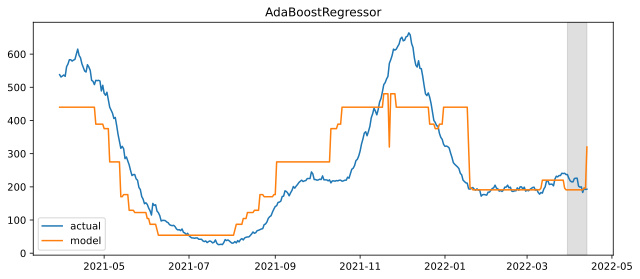

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,65.0289,9069.3306,95.2330,0.6978,0.3851,0.3353


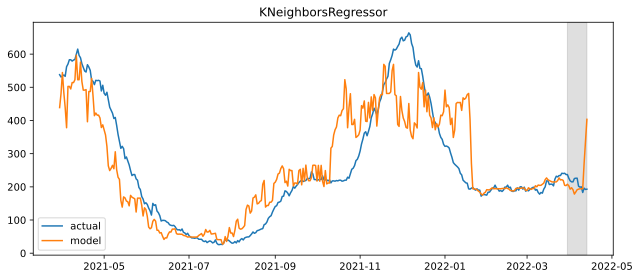

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,34.1050,2587.8226,50.8706,0.9138,0.2321,0.1826


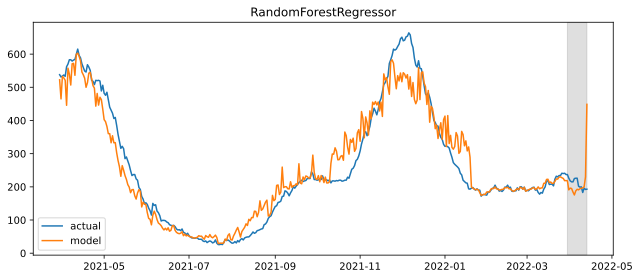

In [7]:
for m in tuned:
    predictions = predict_model(m, data=data)
    plt.figure(figsize=(9, 4))
    plt.plot(data.index, predictions["occupancy"], label="actual")
    plt.plot(data.index, predictions["prediction_label"], label="model")
    plt.axvspan(END_DATE, data.index.max(), alpha=0.25, color='grey')
    plt.title(type(m).__name__)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/regression_{type(m).__name__}.pdf')
    plt.show()